**Chapter 16 – Natural Language Processing with RNNs and Attention**

_This notebook contains all the sample code in chapter 16._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Char-RNN

## Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [8]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [9]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [10]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [11]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [15]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [16]:
dataset = dataset.prefetch(1)

In [17]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model

In [18]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Epoch 1/10
31370/31370 [==============================] - 601s 19ms/step - loss: 1.6220
Epoch 2/10
31370/31370 [==============================] - 604s 19ms/step - loss: 1.5340
Epoch 3/10
31370/31370 [==============================] - 601s 19ms/step - loss: 1.5124
Epoch 4/10
25871/31370 [=======================>......] - ETA: 1:45 - loss: 1.5010

## Using the Model to Generate Text

In [19]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [20]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


'u'

In [21]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

In [22]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [23]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [24]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [25]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the countellance and the belly and the good one str


In [26]:
print(complete_text("t", temperature=1))

toke ob our farteness parce. trust you, tridures al


In [27]:
print(complete_text("t", temperature=2))

tpeniomem lvcer togmaze:
yel 'vall dear. ruli-hapem


## Stateful RNN

In [28]:
tf.random.set_seed(42)

In [29]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [30]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [31]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, #recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [32]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [33]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 6s 18ms/step - loss: 2.6212
Epoch 2/50
313/313 [==============================] - 6s 18ms/step - loss: 2.2411
Epoch 3/50
313/313 [==============================] - 6s 19ms/step - loss: 2.1109
Epoch 4/50
313/313 [==============================] - 6s 19ms/step - loss: 2.0348
Epoch 5/50
313/313 [==============================] - 6s 19ms/step - loss: 1.9846
Epoch 6/50
313/313 [==============================] - 6s 19ms/step - loss: 1.9480
Epoch 7/50
313/313 [==============================] - 6s 19ms/step - loss: 1.9204
Epoch 8/50
313/313 [==============================] - 6s 19ms/step - loss: 1.8988
Epoch 9/50
313/313 [==============================] - 6s 19ms/step - loss: 1.8802
Epoch 10/50
313/313 [==============================] - 6s 19ms/step - loss: 1.8673
Epoch 11/50
313/313 [==============================] - 6s 18ms/step - loss: 1.8538
Epoch 12/50
313/313 [==============================] - 6s 18ms/step - loss: 1.8418
Epoch 13/50
3

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [34]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [35]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [36]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [37]:
tf.random.set_seed(42)

print(complete_text("t"))

ty:
no doing honour this vows wan. believe yourself


# Sentiment Analysis

In [38]:
tf.random.set_seed(42)

You can load the IMDB dataset easily:

In [39]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

In [40]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [41]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In [42]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [43]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [44]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [45]:
train_size, test_size

(25000, 25000)

In [46]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [47]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [48]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [49]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [50]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [51]:
len(vocabulary)

53893

In [52]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [53]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [54]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [55]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [56]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [57]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [58]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 22s 28ms/step - loss: 0.5305 - accuracy: 0.7281
Epoch 2/5
781/781 [==============================] - 22s 28ms/step - loss: 0.3459 - accuracy: 0.8554
Epoch 3/5
781/781 [==============================] - 22s 28ms/step - loss: 0.1913 - accuracy: 0.9319
Epoch 4/5
781/781 [==============================] - 22s 28ms/step - loss: 0.1341 - accuracy: 0.9535
Epoch 5/5
781/781 [==============================] - 22s 28ms/step - loss: 0.1010 - accuracy: 0.9624


Or using manual masking:

In [59]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 22s 28ms/step - loss: 0.5426 - accuracy: 0.7155
Epoch 2/5
781/781 [==============================] - 22s 28ms/step - loss: 0.3477 - accuracy: 0.8555
Epoch 3/5
781/781 [==============================] - 22s 28ms/step - loss: 0.1749 - accuracy: 0.9370
Epoch 4/5
781/781 [==============================] - 22s 28ms/step - loss: 0.1268 - accuracy: 0.9538
Epoch 5/5
781/781 [==============================] - 22s 28ms/step - loss: 0.1069 - accuracy: 0.9599


## Reusing Pretrained Embeddings

In [60]:
tf.random.set_seed(42)

In [61]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [62]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [63]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index


In [64]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5460 - accuracy: 0.7267
Epoch 2/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5129 - accuracy: 0.7494
Epoch 3/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5082 - accuracy: 0.7530
Epoch 4/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5046 - accuracy: 0.7538
Epoch 5/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5017 - accuracy: 0.7561


## Automatic Translation

**주의**: 이 섹션의 코드는 텐서플로 애드온 0.10.0에서 에러가 발생합니다. 0.9.1 버전을 설치하세요.

In [65]:
# !pip install tensorflow-addons==0.9.1

In [66]:
tf.random.set_seed(42)

In [67]:
vocab_size = 100
embed_size = 10

In [68]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)#, training=None)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [69]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [70]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 1s 37ms/step - loss: 4.6052
Epoch 2/2
32/32 [==============================] - 1s 37ms/step - loss: 4.6026


### Bidirectional Recurrent Layers

In [71]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Positional Encoding

In [72]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [73]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

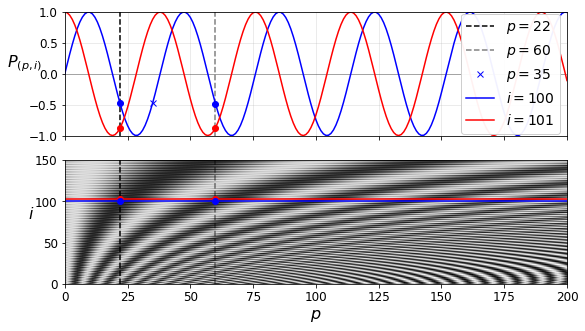

In [74]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [75]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [76]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [77]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [78]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])

# Exercise solutions

## 1. to 7.

See Appendix A.

## 8.
_Exercise:_ Embedded Reber grammars _were used by Hochreiter and Schmidhuber in [their paper](https://homl.info/93) about LSTMs. They are artificial grammars that produce strings such as "BPBTSXXVPSEPE." Check out Jenny Orr's [nice introduction](https://homl.info/108) to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr's page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don't._

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [79]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [80]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [81]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [82]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [83]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

We cannot feed strings directly to an RNN, so we need to encode them somehow. One option would be to one-hot encode each character. Another option is to use embeddings. Let's go for the second option (but since there are just a handful of characters, one-hot encoding would probably be a good option as well). For embeddings to work, we need to convert each string into a sequence of character IDs. Let's write a function for that, using each character's index in the string of possible characters "BEPSTVX":

In [84]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [POSSIBLE_CHARS.index(c) for c in s]

In [85]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

We can now generate the dataset, with 50% good strings, and 50% bad strings:

In [86]:
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [87]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

Let's take a look at the first training sequence:

In [88]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

What classes does it belong to?

In [89]:
y_train[0]

array([1.])

Perfect! We are ready to create the RNN to identify good strings. We build a simple sequence binary classifier:

In [90]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# TF 2.2 & cuDNN 7.6.5에서 에러가 발생하기 때문에 CPU로 실행합니다.
with tf.device('/CPU'):
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


/home/work/.local/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


313/313 [==============================] - 4s 13ms/step - loss: 0.6910 - accuracy: 0.5095 - val_loss: 0.6825 - val_accuracy: 0.5645
Epoch 2/20
313/313 [==============================] - 4s 12ms/step - loss: 0.6678 - accuracy: 0.5659 - val_loss: 0.6635 - val_accuracy: 0.6105
Epoch 3/20
313/313 [==============================] - 4s 12ms/step - loss: 0.6504 - accuracy: 0.5766 - val_loss: 0.6521 - val_accuracy: 0.6110
Epoch 4/20
313/313 [==============================] - 4s 12ms/step - loss: 0.6347 - accuracy: 0.5980 - val_loss: 0.6224 - val_accuracy: 0.6445
Epoch 5/20
313/313 [==============================] - 4s 12ms/step - loss: 0.6054 - accuracy: 0.6361 - val_loss: 0.5779 - val_accuracy: 0.6980
Epoch 6/20
313/313 [==============================] - 4s 12ms/step - loss: 0.5414 - accuracy: 0.7093 - val_loss: 0.4695 - val_accuracy: 0.7795
Epoch 7/20
313/313 [==============================] - 4s 12ms/step - loss: 0.3809 - accuracy: 0.8390 - val_loss: 0.6045 - val_accuracy: 0.6225
Epoch 8/20

Now let's test our RNN on two tricky strings: the first one is bad while the second one is good. They only differ by the second to last character. If the RNN gets this right, it shows that it managed to notice the pattern that the second letter should always be equal to the second to last letter. That requires a fairly long short-term memory (which is the reason why we used a GRU cell).

In [91]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

# TF 2.2 & cuDNN 7.6.5에서 에러가 발생하기 때문에 CPU로 실행합니다.
with tf.device('/CPU'):
    y_proba = model.predict(X_test)

print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))


Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.06%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.97%


Ta-da! It worked fine. The RNN found the correct answers with very high confidence. :)

## 9.
_Exercise: Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from "April 22, 2019" to "2019-04-22")._

Let's start by creating the dataset. We will use random days between 1000-01-01 and 9999-12-31:

In [92]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

Here are a few random dates, displayed in both the input format and the target format:

In [93]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


Let's get the list of all possible characters in the inputs:

In [94]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS)))) + "01234567890, "
INPUT_CHARS

'ADFJMNOSabceghilmnoprstuvy01234567890, '

And here's the list of possible characters in the outputs:

In [95]:
OUTPUT_CHARS = "0123456789-"

Let's write a function to convert a string to a list of character IDs, as we did in the previous exercise:

In [96]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [97]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[7, 11, 19, 22, 11, 16, 9, 11, 20, 38, 28, 26, 37, 38, 33, 26, 33, 31]

In [98]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [99]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [100]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [101]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

### First version: a very basic seq2seq model

Let's first try the simplest possible model: we feed in the input sequence, which first goes through the encoder (an embedding layer followed by a single LSTM layer), which outputs a vector, then it goes through a decoder (a single LSTM layer, followed by a dense output layer), which outputs a sequence of vectors, each representing the estimated probabilities for all possible output character.

Since the decoder expects a sequence as input, we repeat the vector (which is output by the decoder) as many times as the longest possible output sequence.

In [102]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 5s 15ms/step - loss: 1.7985 - accuracy: 0.3575 - val_loss: 1.3444 - val_accuracy: 0.5033
Epoch 2/20
313/313 [==============================] - 4s 12ms/step - loss: 1.4000 - accuracy: 0.5000 - val_loss: 1.6329 - val_accuracy: 0.4155
Epoch 3/20
313/313 [==============================] - 4s 12ms/step - loss: 1.1020 - accuracy: 0.6110 - val_loss: 0.9927 - val_accuracy: 0.6363
Epoch 4/20
313/313 [==============================] - 4s 12ms/step - loss: 0.7934 - accuracy: 0.7056 - val_loss: 0.6830 - val_accuracy: 0.7408
Epoch 5/20
313/313 [==============================] - 4s 12ms/step - loss: 0.8209 - accuracy: 0.7061 - val_loss: 0.8538 - val_accuracy: 0.6841
Epoch 6/20
313/313 [==============================] - 4s 12ms/step - loss: 0.7185 - accuracy: 0.7416 - val_loss: 0.4656 - val_accuracy: 0.8170
Epoch 7/20
313/313 [==============================] - 4s 12ms/step - loss: 0.3817 - accuracy: 0.8525 - val_loss: 0.3208 - val_accuracy: 0.8737

Looks great, we reach 100% validation accuracy! Let's use the model to make some predictions. We will need to be able to convert a sequence of character IDs to a readable string:

In [103]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

Now we can use the model to convert some dates

In [104]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [105]:
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2009-09-17
1789-07-14


Perfect! :)

However, since the model was only trained on input strings of length 18 (which is the length of the longest date), it does not perform well if we try to use it to make predictions on shorter sequences:

In [106]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [107]:
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-02-02
1789-09-14


Oops! We need to ensure that we always pass sequences of the same length as during training, using padding if necessary. Let's write a little helper function for that:

In [108]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = model.predict_classes(X)
    return ids_to_date_strs(ids)

In [109]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

['2020-05-02', '1789-07-14']

Cool! Granted, there are certainly much easier ways to write a date conversion tool (e.g., using regular expressions or even basic string manipulation), but you have to admit that using neural networks is way cooler. ;-)

However, real-life sequence-to-sequence problems will usually be harder, so for the sake of completeness, let's build a more powerful model.

### Second version: feeding the shifted targets to the decoder (teacher forcing)

Instead of feeding the decoder a simple repetition of the encoder's output vector, we can feed it the target sequence, shifted by one time step to the right. This way, at each time step the decoder will know what the previous target character was. This should help is tackle more complex sequence-to-sequence problems.

Since the first output character of each target sequence has no previous character, we will need a new token to represent the start-of-sequence (sos).

During inference, we won't know the target, so what will we feed the decoder? We can just predict one character at a time, starting with an sos token, then feeding the decoder all the characters that were predicted so far (we will look at this in more details later in this notebook).

But if the decoder's LSTM expects to get the previous target as input at each step, how shall we pass it it the vector output by the encoder? Well, one option is to ignore the output vector, and instead use the encoder's LSTM state as the initial state of the decoder's LSTM (which requires that encoder's LSTM must have the same number of units as the decoder's LSTM).

Now let's create the decoder's inputs (for training, validation and testing). The sos token will be represented using the last possible output character's ID + 1.

In [110]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

Let's take a look at the decoder's training inputs:

In [111]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

Now let's build the model. It's not a simple sequential model anymore, so let's use the functional API:

In [112]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 5s 15ms/step - loss: 1.6901 - accuracy: 0.3714 - val_loss: 1.4141 - val_accuracy: 0.4604
Epoch 2/10
313/313 [==============================] - 4s 12ms/step - loss: 1.2042 - accuracy: 0.5562 - val_loss: 0.8934 - val_accuracy: 0.6841
Epoch 3/10
313/313 [==============================] - 3s 11ms/step - loss: 0.6149 - accuracy: 0.7875 - val_loss: 0.3466 - val_accuracy: 0.8929
Epoch 4/10
313/313 [==============================] - 4s 12ms/step - loss: 0.1896 - accuracy: 0.9580 - val_loss: 0.0965 - val_accuracy: 0.9876
Epoch 5/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0862 - accuracy: 0.9874 - val_loss: 0.0402 - val_accuracy: 0.9985
Epoch 6/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0275 - accuracy: 0.9995 - val_loss: 0.0228 - val_accuracy: 0.9996
Epoch 7/10
313/313 [==============================] - 3s 11ms/step - loss: 0.0481 - accuracy: 0.9916 - val_loss: 0.0407 - val_accuracy: 0.9964

This model also reaches 100% validation accuracy, but it does so even faster.

Let's once again use the model to make some predictions. This time we need to predict characters one by one.

In [113]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [114]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Works fine! :)

### Third version: using TF-Addons's seq2seq implementation

Let's build exactly the same model, but using TF-Addon's seq2seq API. The implementation below is almost very similar to the TFA example higher in this notebook, except without the model input to specify the output sequence length, for simplicity (but you can easily add it back in if you need it for your projects, when the output sequences have very different lengths).

In [115]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 11s 35ms/step - loss: 1.6782 - accuracy: 0.3686 - val_loss: 1.4574 - val_accuracy: 0.4304
Epoch 2/15
313/313 [==============================] - 10s 32ms/step - loss: 1.3472 - accuracy: 0.4792 - val_loss: 1.2293 - val_accuracy: 0.5292
Epoch 3/15
313/313 [==============================] - 10s 33ms/step - loss: 0.8811 - accuracy: 0.6861 - val_loss: 0.5698 - val_accuracy: 0.8045
Epoch 4/15
313/313 [==============================] - 10s 33ms/step - loss: 0.3547 - accuracy: 0.8915 - val_loss: 0.1697 - val_accuracy: 0.9689
Epoch 5/15
313/313 [==============================] - 10s 32ms/step - loss: 0.1385 - accuracy: 0.9768 - val_loss: 0.0644 - val_accuracy: 0.9953
Epoch 6/15
313/313 [==============================] - 10s 32ms/step - loss: 0.0423 - accuracy: 0.9983 - val_loss: 0.0331 - val_accuracy: 0.9988
Epoch 7/15
313/313 [==============================] - 10s 32ms/step - loss: 0.0206 - accuracy: 0.9998 - val_loss: 0.0171 - val_accuracy:

And once again, 100% validation accuracy! To use the model, we can just reuse the `predict_date_strs()` function:

In [116]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

However, there's a much more efficient way to perform inference. Until now, during inference, we've run the model once for each new character. Instead, we can create a new decoder, based on the previously trained layers, but using a `GreedyEmbeddingSampler` instead of a `TrainingSampler`.

At each time step, the `GreedyEmbeddingSampler` will compute the argmax of the decoder's outputs, and run the resulting token IDs through the decoder's embedding layer. Then it will feed the resulting embeddings to the decoder's LSTM cell at the next time step. This way, we only need to run the decoder once to get the full prediction.

In [117]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

A few notes:
* The `GreedyEmbeddingSampler` needs the `start_tokens` (a vector containing the start-of-sequence ID for each decoder sequence), and the `end_token` (the decoder will stop decoding a sequence once the model outputs this token).
* We must set `maximum_iterations` when creating the `BasicDecoder`, or else it may run into an infinite loop (if the model never outputs the end token for at least one of the sequences). This would force you would to restart the Jupyter kernel.
* The decoder inputs are not needed anymore, since all the decoder inputs are generated dynamically based on the outputs from the previous time step.
* The model's outputs are `final_outputs.sample_id` instead of the softmax of `final_outputs.rnn_outputs`. This allows us to directly get the argmax of the model's outputs. If you prefer to have access to the logits, you can replace `final_outputs.sample_id` with `final_outputs.rnn_outputs`.

Now we can write a simple function that uses the model to perform the date format conversion:

In [118]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [119]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Let's check that it really is faster:

In [120]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])

607 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

61.2 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's more than a 10x speedup! And it would be even more if we were handling longer sequences.

### Fourth version: using TF-Addons's seq2seq implementation with a scheduled sampler

**Warning**: due to a TF bug, this version only works using TensorFlow 2.2.

When we trained the previous model, at each time step _t_ we gave the model the target token for time step _t_ - 1. However, at inference time, the model did not get the previous target at each time step. Instead, it got the previous prediction. So there is a discrepancy between training and inference, which may lead to disappointing performance. To alleviate this, we can gradually replace the targets with the predictions, during training. For this, we just need to replace the `TrainingSampler` with a `ScheduledEmbeddingTrainingSampler`, and use a Keras callback to gradually increase the `sampling_probability` (i.e., the probability that the decoder will use the prediction from the previous time step rather than the target for the previous time step).

In [122]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(
    sampling_probability=0.,
    embedding_fn=decoder_embedding_layer)
# we must set the sampling_probability after creating the sampler
# (see https://github.com/tensorflow/addons/pull/1714)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(
    on_epoch_begin=update_sampling_probability)
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])

Epoch 1/20
313/313 [==============================] - 15s 48ms/step - loss: 1.6782 - accuracy: 0.3686 - val_loss: 1.4575 - val_accuracy: 0.4304
Epoch 2/20
313/313 [==============================] - 14s 46ms/step - loss: 1.3857 - accuracy: 0.4590 - val_loss: 1.2498 - val_accuracy: 0.5246
Epoch 3/20
313/313 [==============================] - 14s 46ms/step - loss: 1.0742 - accuracy: 0.5999 - val_loss: 0.8688 - val_accuracy: 0.6754
Epoch 4/20
313/313 [==============================] - 14s 46ms/step - loss: 0.6618 - accuracy: 0.7601 - val_loss: 0.4599 - val_accuracy: 0.8322
Epoch 5/20
313/313 [==============================] - 14s 46ms/step - loss: 0.3445 - accuracy: 0.8854 - val_loss: 0.2544 - val_accuracy: 0.9220
Epoch 6/20
313/313 [==============================] - 14s 45ms/step - loss: 0.2643 - accuracy: 0.9213 - val_loss: 0.1739 - val_accuracy: 0.9510
Epoch 7/20
313/313 [==============================] - 14s 45ms/step - loss: 0.1338 - accuracy: 0.9649 - val_loss: 0.1080 - val_accuracy:

Not quite 100% validation accuracy, but close enough!

For inference, we could do the exact same thing as earlier, using a `GreedyEmbeddingSampler`. However, just for the sake of completeness, let's use a `SampleEmbeddingSampler` instead. It's almost the same thing, except that instead of using the argmax of the model's output to find the token ID, it treats the outputs as logits and uses them to sample a token ID randomly. This can be useful when you want to generate text. The `softmax_temperature` argument serves the 
same purpose as when we generated Shakespeare-like text (the higher this argument, the more random the generated text will be).

In [123]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [124]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [125]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2000-05-01']

Dates look good at room temperature. Now let's heat things up a bit:

In [126]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"],
                           temperature=5.)

['7179307-29', '200040?400']

Oops, the dates are overcooked, now. Let's call them "creative" dates.

### Fifth version: using TFA seq2seq, the Keras subclassing API and attention mechanisms

The sequences in this problem are pretty short, but if we wanted to tackle longer sequences, we would probably have to use attention mechanisms. While it's possible to code our own implementation, it's simpler and more efficient to use TF-Addons's implementation instead. Let's do that now, this time using Keras' subclassing API.

**Warning**: due to a TensorFlow bug (see [this issue](https://github.com/tensorflow/addons/issues/1153) for details), the `get_initial_state()` method fails in eager mode, so for now we have to use the subclassing API, as Keras automatically calls `tf.function()` on the `call()` method (so it runs in graph mode).

In this implementation, we've reverted back to using the `TrainingSampler`, for simplicity (but you can easily tweak it to use a `ScheduledEmbeddingTrainingSampler` instead). We also use a `GreedyEmbeddingSampler` during inference, so this class is pretty easy to use:

In [127]:
class DateTranslation(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32,
                 decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)
        self.encoder_embedding = keras.layers.Embedding(
            input_dim=len(INPUT_CHARS) + 1,
            output_dim=encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units,
                                         return_sequences=True,
                                         return_state=True)
        self.decoder_embedding = keras.layers.Embedding(
            input_dim=len(OUTPUT_CHARS) + 2,
            output_dim=decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(
            cell=decoder_inner_cell,
            attention_mechanism=self.attention)
        output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.TrainingSampler(),
            output_layer=output_layer)
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(
                embedding_fn=self.decoder_embedding),
            output_layer=output_layer,
            maximum_iterations=max_output_length)

    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
            encoder_embeddings,
            training=training)
        encoder_state = [encoder_state_h, encoder_state_c]

        self.attention(encoder_outputs,
                       setup_memory=True)
        
        decoder_embeddings = self.decoder_embedding(decoder_input)

        decoder_initial_state = self.decoder_cell.get_initial_state(
            decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(
            cell_state=encoder_state)
        
        if training:
            decoder_outputs, _, _ = self.decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                training=training)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            decoder_outputs, _, _ = self.inference_decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                start_tokens=start_tokens,
                end_token=0)

        return tf.nn.softmax(decoder_outputs.rnn_output)

In [128]:
np.random.seed(42)
tf.random.set_seed(42)

model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/25
313/313 [==============================] - 15s 48ms/step - loss: 2.1391 - accuracy: 0.2346 - val_loss: 1.9953 - val_accuracy: 0.2805
Epoch 2/25
313/313 [==============================] - 14s 44ms/step - loss: 2.0472 - accuracy: 0.2751 - val_loss: 2.7959 - val_accuracy: 0.1375
Epoch 3/25
313/313 [==============================] - 14s 44ms/step - loss: 1.4588 - accuracy: 0.4721 - val_loss: 1.2255 - val_accuracy: 0.5621
Epoch 4/25
313/313 [==============================] - 14s 44ms/step - loss: 1.0513 - accuracy: 0.6208 - val_loss: 0.7987 - val_accuracy: 0.7031
Epoch 5/25
313/313 [==============================] - 14s 44ms/step - loss: 0.4682 - accuracy: 0.8495 - val_loss: 0.2970 - val_accuracy: 0.9006
Epoch 6/25
313/313 [==============================] - 14s 44ms/step - loss: 0.2616 - accuracy: 0.9138 - val_loss: 0.1722 - val_accuracy: 0.9423
Epoch 7/25
313/313 [==============================] - 14s 44ms/step - loss: 0.0627 - accuracy: 0.9852 - val_loss: 0.0324 - val_accuracy:

Not quite 100% validation accuracy, but close. It took a bit longer to converge this time, but there were also more parameters and more computations per iteration. And we did not use a scheduled sampler.

To use the model, we can write yet another little function:

In [129]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
    Y_probas = model.predict([X, X_decoder])
    Y_pred = tf.argmax(Y_probas, axis=-1)
    return ids_to_date_strs(Y_pred)

In [130]:
fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

There are still a few interesting features from TF-Addons that you may want to look at:
* Using a `BeamSearchDecoder` rather than a `BasicDecoder` for inference. Instead of outputing the character with the highest probability, this decoder keeps track of the several candidates, and keeps only the most likely sequences of candidates (see chapter 16 in the book for more details).
* Setting masks or specifying `sequence_length` if the input or target sequences may have very different lengths.
* Using a `ScheduledOutputTrainingSampler`, which gives you more flexibility than the `ScheduledEmbeddingTrainingSampler` to decide how to feed the output at time _t_ to the cell at time _t_+1. By default it feeds the outputs directly to cell, without computing the argmax ID and passing it through an embedding layer. Alternatively, you specify a `next_inputs_fn` function that will be used to convert the cell outputs to inputs at the next step.

## 10.
_Exercise: Go through TensorFlow's [Neural Machine Translation with Attention tutorial](https://homl.info/nmttuto)._

Simply open the Colab and follow its instructions. Alternatively, if you want a simpler example of using TF-Addons's seq2seq implementation for Neural Machine Translation (NMT), look at the solution to the previous question. The last model implementation will give you a simpler example of using TF-Addons to build an NMT model using attention mechanisms.

## 11.
_Exercise: Use one of the recent language models (e.g., GPT) to generate more convincing Shakespearean text._

**주의**: 이 연습문제 코드를 실행하려면 허깅페이스(huggingface)의 트랜스포머 라이브러리를 설치해야 합니다.

In [131]:
# !pip install transformers

The simplest way to use recent language models is to use the excellent [transformers library](https://huggingface.co/transformers/), open sourced by Hugging Face. It provides many modern neural net architectures (including BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet and more) for Natural Language Processing (NLP), including many pretrained models. It relies on either TensorFlow or PyTorch. Best of all: it's amazingly simple to use.

First, let's load a pretrained model. In this example, we will use OpenAI's GPT model, with an additional Language Model on top (just a linear layer with weights tied to the input embeddings). Let's import it and load the pretrained weights (this will download about 445MB of data to `~/.cache/torch/transformers`):

In [132]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")


If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFOpenAIGPTLMHeadModel for predictions without further training.


Next we will need a specialized tokenizer for this model. This one will try to use the [spaCy](https://spacy.io/) and [ftfy](https://pypi.org/project/ftfy/) libraries if they are installed, or else it will fall back to BERT's `BasicTokenizer` followed by Byte-Pair Encoding (which should be fine for most use cases).

In [133]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

Now let's use the tokenizer to tokenize and encode the prompt text:

In [134]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

Easy! Next, let's use the model to generate text after the prompt. We will generate 5 different sentences, each starting with the prompt text, followed by 40 additional tokens. For an explanation of what all the hyperparameters do, make sure to check out this great [blog post](https://huggingface.co/blog/how-to-generate) by Patrick von Platen (from Hugging Face). You can play around with the hyperparameters to try to obtain better results.

In [135]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   240,   509,   481,  9313,  6640,   498,  1389, 11031,
          239,   481,  2204,   544,   525,   481,  4906,  3659,   498,
          481,   653,   911,   498,     8, 38648,   641,  1236,   481,
         5018,   498,   481, 21368,   488,   481,  6404,   948, 35174,
          715,  1076,   763,   641,  2520],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   980,  1981,   557,   481,  2827,   498,   481,  1028,
          498,  9606,   239,   244, 40477,   244,   862,  1256,   240,
          547,  2185,   239,   244,  7395, 21800,   513,  2185,   239,
          244,   599,   636,   512,   649,   485,   788,   257,   244,
        40477,   481,  2228,   535,   741],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239,   481,  3549,   498,   589,   547, 16375,   240,
         4258

Now let's decode the generated sequences and print them:

In [136]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle, was the largest collection of such affairs. the problem is that the descendents of the earls of astoria were under the rule of the sages and the throne took precedence over those who were forced
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle has passed as the beginning of the age of kings. " 
 " well done, my lord. " velvet complimented her lord. " what would you like to see? " 
 the lady's eyes
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle. the bones of all my comrades, including those of my ex - lady, lie in the hollow beneath the eaves. the crow's eye, the great griffin - king, has set his battlea
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle he was born in, this door he had placed before him, i

You can try more recent (and larger) models, such as GPT-2, CTRL, Transformer-XL or XLNet, which are all available as pretrained models in the transformers library, including variants with Language Models on top. The preprocessing steps vary slightly between models, so make sure to check out this [generation example](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py) from the transformers documentation (this example uses PyTorch, but it will work with very little tweaks, such as adding `TF` at the beginning of the model class name, removing the `.to()` method calls, and using `return_tensors="tf"` instead of `"pt"`.

Hope you enjoyed this chapter! :)